# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats



# Etape 1: charger les données

<span style = "color:red">Le module *fonction_applications.py* contient toutes les fonctions et classes créées pour faire fonctionner ce notebook.
Voici un résumé de ce qu'elles font  </span>

* *oversample_data* et *undersample_data* prennent alltxts et alllabs et respectivement sur-échantillonent ou sous-échantillonent la classe respectivement minoritaire ou majoritaire pour qu'elles soient présente en quantité égales
* *TextPreprocessor* est une classe qui s'occupe du pretraitement des données (retirer ponctuation,majuscule, chiffre, retirer stop words, stemming etc.) grâce aux méthodes preprocess et transform, ainsi que les diverses fonctions pour la distribution de zipf, les wordclouds etc.
* *TextProcessorTransformer* hérite de la classe ci-dessus et en fait un objet sklearn qui peut faire l'objet d'une grid search
* *plot_scores* prennent un objet GridSearchCV et des paramètres et tracent le f1 moyen en fonction du paramètre donné en entrée
* Enfin *predict_from_txt* prends un fichier txt qui contient sur chaque ligne un texte et applique l'infèrence à partir du modèle et des paramètres donnés en entrée, avant d'exrire les resultats dans un fichier

In [1]:
from fonctions_application import TextPreprocessor
from fonctions_application import TextPreprocessorTransformer 
from fonctions_application import plot_scores
from fonctions_application import predict_from_txt
from fonctions_application import oversample_data
from fonctions_application import undersample_data

In [2]:
from sklearn.model_selection import train_test_split
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
import random
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import re
import string
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [3]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [4]:
fname = "ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

alltxts,alllabs = load_pres(fname)


In [5]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

27162 27162
<105:1> En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.

1
<823:34> Dans cette perspective, je demanderai à une grande personnalité de l'industrie de me faire des propositions sur les moyens de renforcer la coopération scientifique et industrielle avec les pays émergents, les transferts de technologie vers ces pays et le financement de leur développement propre.

1


## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>

$\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

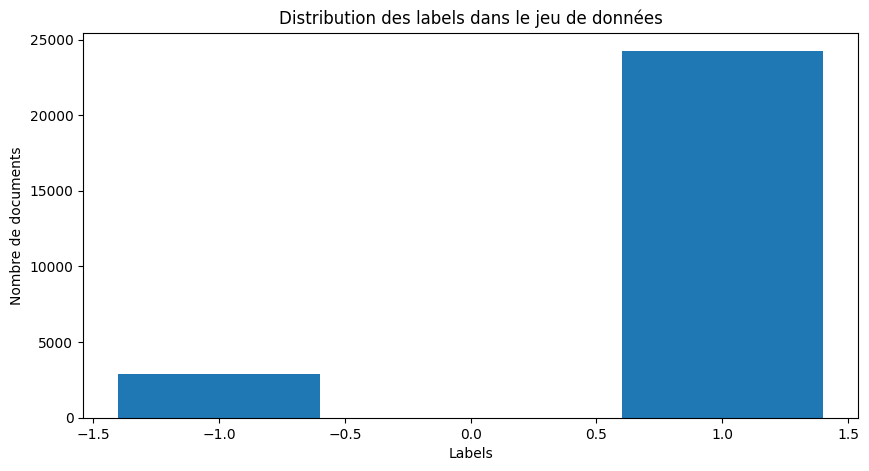

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Compter les documents pour chaque label
label_counts = Counter(alllabs)

# Trier les labels et les fréquences
sorted_labels, sorted_counts = zip(*sorted(label_counts.items()))

# Afficher un histogramme des fréquences des labels
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_counts)
plt.xlabel("Labels")
plt.ylabel("Nombre de documents")
plt.title("Distribution des labels dans le jeu de données")
plt.show()


<span style = "color:red">Ici les données sont deséquilibrées, il est donc nécessaire de les rééquilibrer</span>

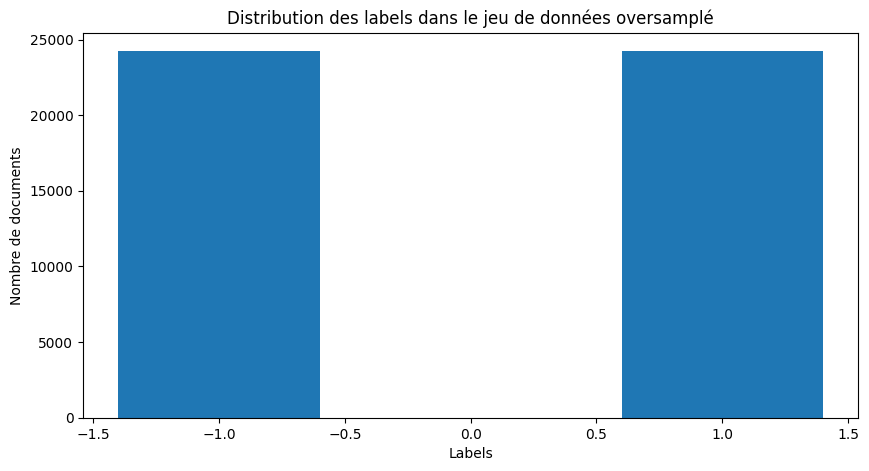

In [7]:
balanced_texts_over, balanced_labels_over = oversample_data(alltxts, alllabs)

label_counts = Counter(balanced_labels_over)

# Trier les labels et les fréquences
sorted_labels, sorted_counts = zip(*sorted(label_counts.items()))

# Afficher un histogramme des fréquences des labels
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_counts)
plt.xlabel("Labels")
plt.ylabel("Nombre de documents")
plt.title("Distribution des labels dans le jeu de données oversamplé")
plt.show()


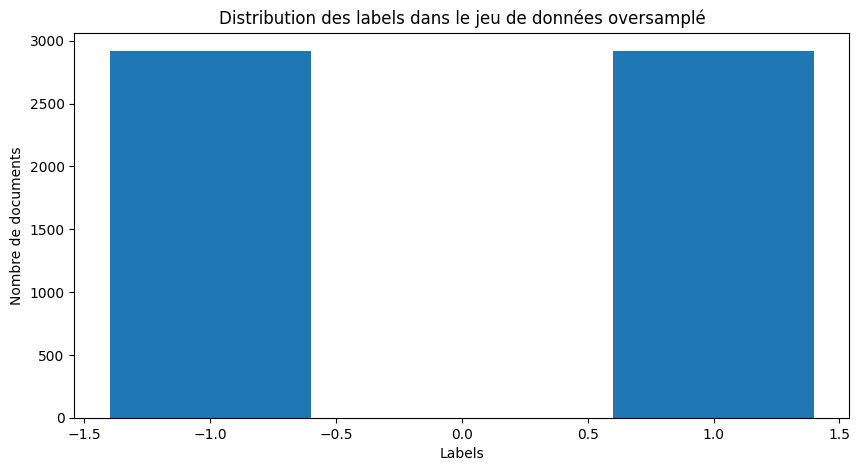

In [8]:
balanced_texts_under, balanced_labels_under = undersample_data(alltxts, alllabs)

label_counts = Counter(balanced_labels_under)

# Trier les labels et les fréquences
sorted_labels, sorted_counts = zip(*sorted(label_counts.items()))

# Afficher un histogramme des fréquences des labels
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_counts)
plt.xlabel("Labels")
plt.ylabel("Nombre de documents")
plt.title("Distribution des labels dans le jeu de données oversamplé")
plt.show()


<span style = "color:red">On a réussi à équilibrer les données. On choisi d'undersampler plutôt que d'oversampler pour des raisons de temps d'exécution (le grid search ci-dessous a pris plus de 100 minutes sans donner de résultat)</span>

In [9]:
alltxts,alllabs=balanced_texts_under, balanced_labels_under

# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [10]:
positive_indices = [i for i, label in enumerate(alllabs) if label == 1]
negative_indices = [i for i, label in enumerate(alllabs) if label == -1]

random_positive_index = random.choice(positive_indices)
random_negative_index = random.choice(negative_indices)

exemple1 = alltxts[random_positive_index]
exemple2 = alltxts[random_negative_index]

print(exemple1)
print(exemple2)

preprocessing_options = [
    {"remove_punct": True, "lowercase": True, "remove_digits": True, "remove_stopwords": True},
    {"remove_punct": False, "lowercase": True, "remove_digits": True, "remove_stopwords": True},
    {"remove_punct": True, "lowercase": False, "remove_digits": True, "remove_stopwords": True},
    {"remove_punct": True, "lowercase": True, "remove_digits": False, "remove_stopwords": True},
    {"remove_punct": True, "lowercase": True, "remove_digits": True, "remove_stopwords": False},
]

# Appliquer les différents prétraitements et afficher les résultats
for i, options in enumerate(preprocessing_options):
    preprocessor = TextPreprocessor(**options)
    preprocessor.transform([exemple1, exemple2])
    preprocessed_text1 = preprocessor.preprocessed_texts[0]
    preprocessed_text2 = preprocessor.preprocessed_texts[1]
    
    print(f"Prétraitement {i+1}: {options}")
    print("Texte 1 prétraité:", preprocessed_text1)
    print("Texte 2 prétraité:", preprocessed_text2)
    print()



<6:12> Je compléterai ce trait en ajoutant que si cela avait été le cas, la face de la terre en aurait été, à n'en pas douter, profondément changée.

<414:6> Saint-Pierre-et-Miquelon, c'est la France aux portes du continent nord-américain, la France tout contre les côtes du Canada c'est le savoir-faire français, c'est un avant-poste de la culture française à la lisière de l'Amérique.

Prétraitement 1: {'remove_punct': True, 'lowercase': True, 'remove_digits': True, 'remove_stopwords': True}
Texte 1 prétraité: je compléterai ce trait en ajoutant que si cela avait été le cas la face de la terre en aurait été à nen pas douter profondément changée
Texte 2 prétraité: saintpierreetmiquelon cest la france aux portes du continent nordaméricain la france tout contre les côtes du canada cest le savoirfaire français cest un avantposte de la culture française à la lisière de lamérique

Prétraitement 2: {'remove_punct': False, 'lowercase': True, 'remove_digits': True, 'remove_stopwords': True}
Text

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


100 mots les plus fréquents : [('a', 760), ('plus', 759), ('cest', 689), ('monsieur', 616), ('nom', 587), ('france', 550), ('aussi', 539), ('président', 522), ('cette', 515), ('pays', 447), ('tout', 354), ('tous', 335), ('messieurs', 324), ('comme', 310), ('bien', 302), ('mesdames', 283), ('dune', 271), ('monde', 258), ('français', 253), ('entre', 252), ('si', 249), ('dun', 228), ('date', 222), ('aujourdhui', 221), ('très', 219), ('faire', 215), ('où', 214), ('sans', 209), ('être', 201), ('leurope', 197), ('jai', 196), ('doit', 194), ('deux', 192), ('quil', 188), ('encore', 187), ('fait', 177), ('faut', 172), ('dont', 164), ('paix', 160), ('ministre', 160), ('cela', 159), ('premier', 156), ('dire', 151), ('leurs', 150), ('politique', 149), ('temps', 148), ('développement', 147), ('vie', 145), ('nest', 144), ('européenne', 142), ('depuis', 138), ('ensemble', 136), ('toujours', 136), ('lunion', 135), ('notamment', 131), ('ans', 130), ('ici', 129), ('toutes', 128), ('beaucoup', 127), ('gr

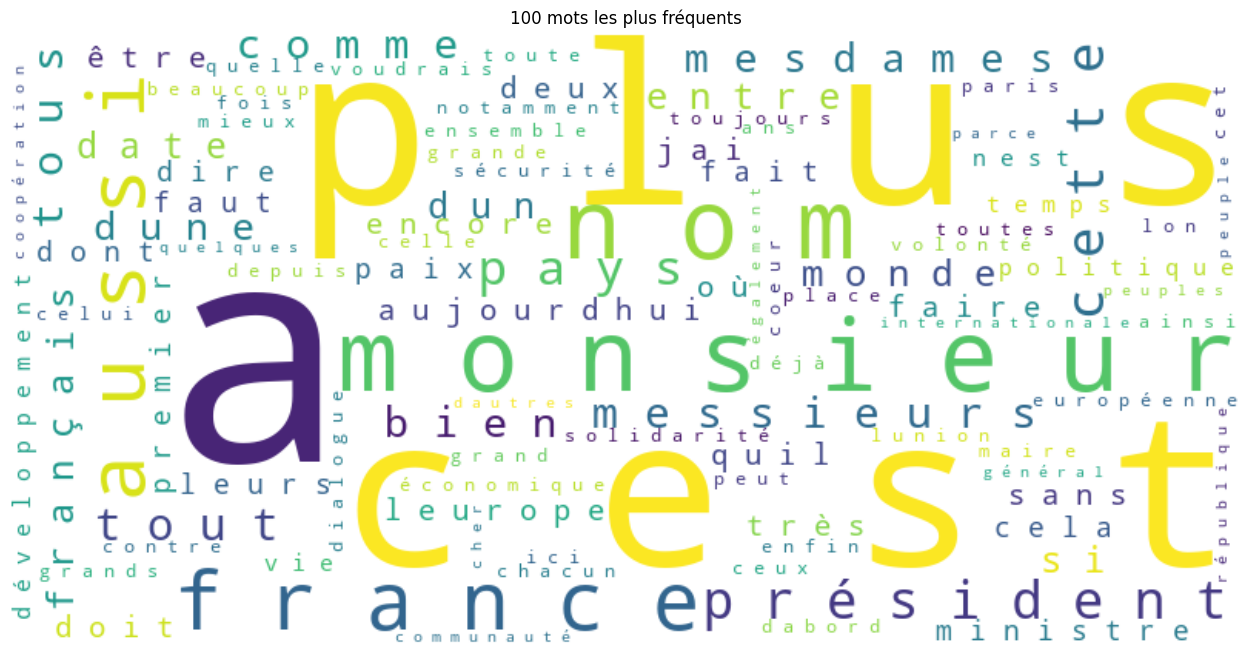

100 mots avec la plus grande fréquence documentaire : [('cest', 3.226252425818213), ('plus', 3.261797363237624), ('monsieur', 3.3003603979719345), ('france', 3.406671032466081), ('aussi', 3.4200683620379024), ('président', 3.447413815928431), ('cette', 3.506554390972371), ('nom', 3.6293394115214097), ('pays', 3.653379030707556), ('tout', 3.845972137823341), ('tous', 3.8974206996593828), ('messieurs', 3.9748787586983867), ('bien', 4.0159804343839385), ('comme', 4.0159804343839385), ('mesdames', 4.062500450018831), ('monde', 4.158543499038808), ('dune', 4.174804019910589), ('français', 4.174804019910589), ('aujourdhui', 4.2692948633315115), ('si', 4.273809543686038), ('entre', 4.28290051538729), ('dun', 4.301334217076128), ('faire', 4.320114111727724), ('très', 4.334434165502473), ('date', 4.383705214509256), ('être', 4.388768516465802), ('où', 4.4041140861404635), ('sans', 4.409282056298906), ('doit', 4.419698817157161), ('leurope', 4.44622557149059), ('encore', 4.457036487594806), ('de

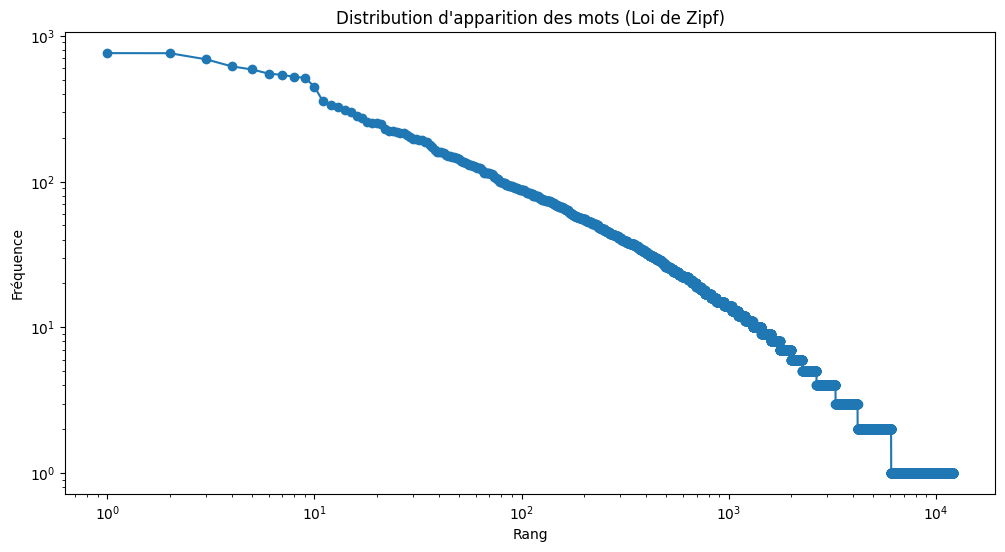

100 bigrammes les plus fréquents : [(('monsieur', 'président'), 422), (('mesdames', 'messieurs'), 277), (('lunion', 'européenne'), 84), (('nom', 'nom'), 80), (('monsieur', 'maire'), 74), (('premier', 'ministre'), 63), (('doit', 'être'), 54), (('tout', 'lheure'), 50), (('bien', 'sûr'), 48), (('cest', 'aussi'), 47), (('chers', 'amis'), 44), (('deux', 'pays'), 40), (('plus', 'plus'), 40), (('france', 'a'), 34), (('tous', 'ceux'), 33), (('nations', 'unies'), 33), (('monsieur', 'premier'), 31), (('mise', 'oeuvre'), 29), (('plus', 'loin'), 29), (('ny', 'a'), 28), (('président', 'mesdames'), 27), (('président', 'république'), 27), (('nom', 'a'), 26), (('entre', 'deux'), 26), (('cette', 'année'), 25), (('cest', 'vrai'), 25), (('droits', 'lhomme'), 25), (('président', 'cher'), 24), (('moment', 'où'), 24), (('communauté', 'internationale'), 24), (('plus', 'grande'), 24), (('cest', 'pourquoi'), 24), (('lutte', 'contre'), 23), (('tout', 'fait'), 23), (('cher', 'ami'), 22), (('quil', 'faut'), 22), 

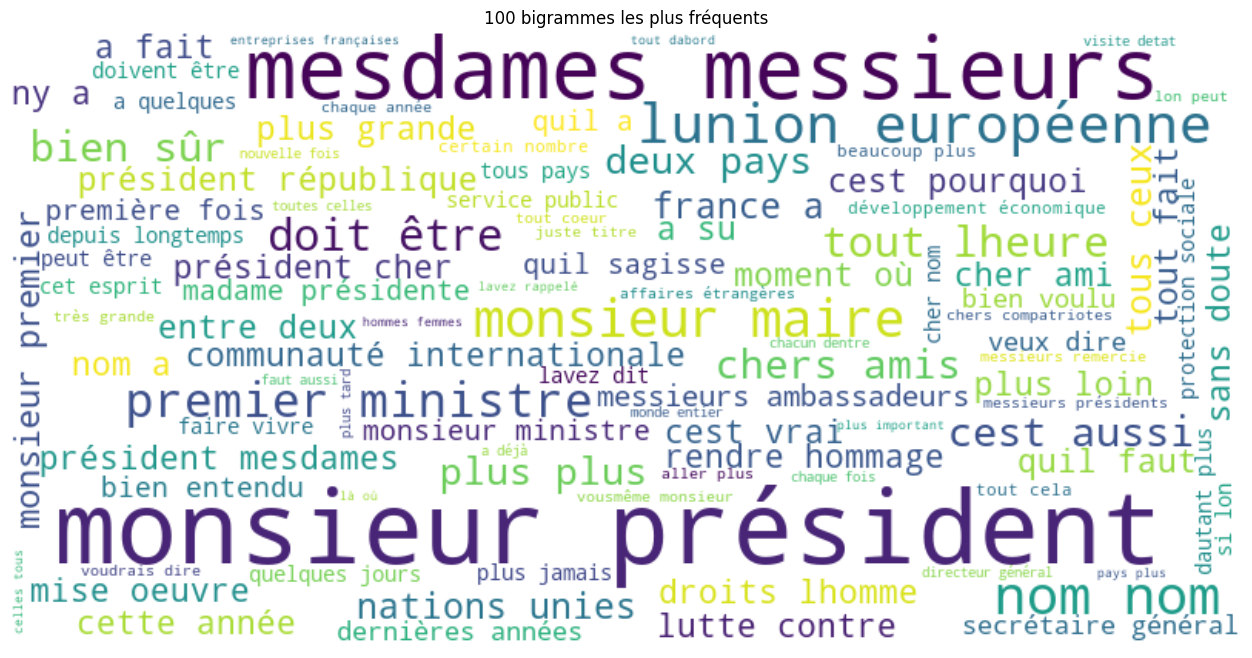

100 trigrammes les plus fréquents : [(('nom', 'nom', 'nom'), 35), (('président', 'mesdames', 'messieurs'), 25), (('monsieur', 'président', 'cher'), 23), (('monsieur', 'président', 'mesdames'), 23), (('monsieur', 'premier', 'ministre'), 22), (('mesdames', 'messieurs', 'ambassadeurs'), 20), (('président', 'cher', 'ami'), 18), (('aller', 'plus', 'loin'), 15), (('monsieur', 'président', 'république'), 15), (('vousmême', 'monsieur', 'président'), 14), (('mesdames', 'messieurs', 'remercie'), 13), (('toutes', 'celles', 'tous'), 13), (('celles', 'tous', 'ceux'), 13), (('mesdames', 'messieurs', 'chers'), 13), (('messieurs', 'chers', 'amis'), 12), (('mesdames', 'messieurs', 'députés'), 11), (('monsieur', 'directeur', 'général'), 11), (('entre', 'deux', 'pays'), 11), (('ministre', 'mesdames', 'messieurs'), 10), (('fonds', 'monétaire', 'international'), 10), (('tout', 'lheure', 'monsieur'), 10), (('honneur', 'monsieur', 'président'), 9), (('sans', 'aucun', 'doute'), 9), (('a', 'quelques', 'jours')

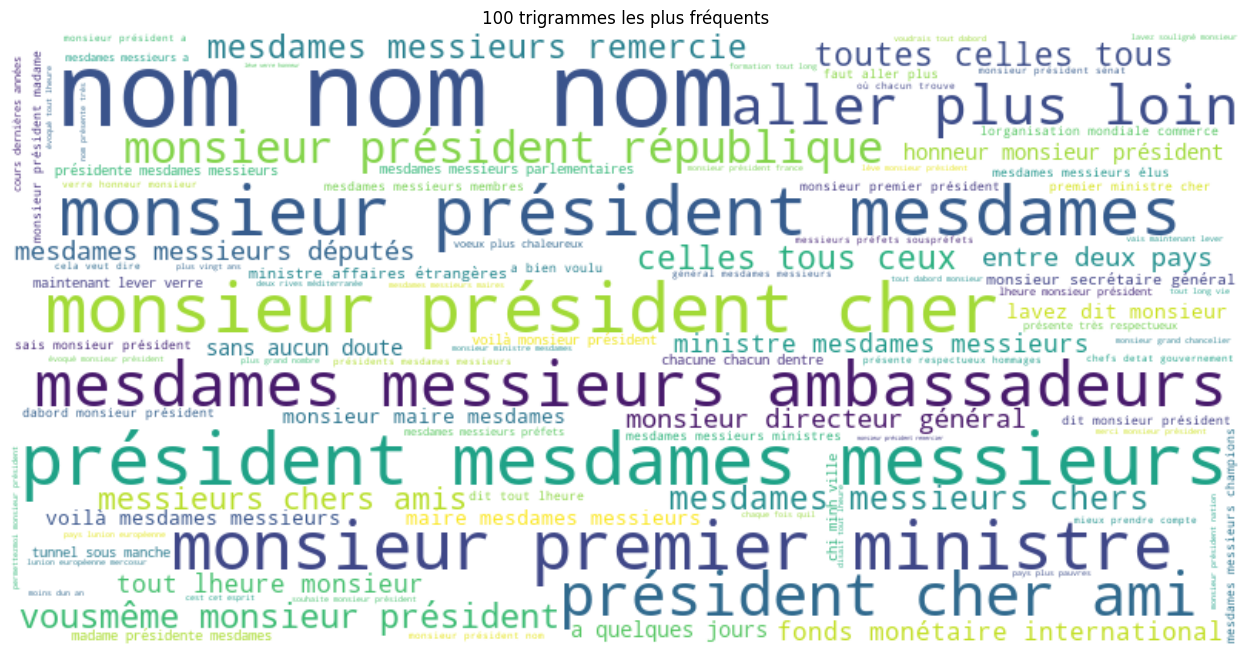

Vocabulary size: 12083
100 most common words: [('a', 760), ('plus', 759), ('cest', 689), ('monsieur', 616), ('nom', 587), ('france', 550), ('aussi', 539), ('président', 522), ('cette', 515), ('pays', 447), ('tout', 354), ('tous', 335), ('messieurs', 324), ('comme', 310), ('bien', 302), ('mesdames', 283), ('dune', 271), ('monde', 258), ('français', 253), ('entre', 252), ('si', 249), ('dun', 228), ('date', 222), ('aujourdhui', 221), ('très', 219), ('faire', 215), ('où', 214), ('sans', 209), ('être', 201), ('leurope', 197), ('jai', 196), ('doit', 194), ('deux', 192), ('quil', 188), ('encore', 187), ('fait', 177), ('faut', 172), ('dont', 164), ('paix', 160), ('ministre', 160), ('cela', 159), ('premier', 156), ('dire', 151), ('leurs', 150), ('politique', 149), ('temps', 148), ('développement', 147), ('vie', 145), ('nest', 144), ('européenne', 142), ('depuis', 138), ('ensemble', 136), ('toujours', 136), ('lunion', 135), ('notamment', 131), ('ans', 130), ('ici', 129), ('toutes', 128), ('beauc

In [11]:
preprocessor = TextPreprocessor(lowercase=True, remove_punct=True, remove_digits=True,language="french")

# Preprocess texts
preprocessor.transform(alltxts)

tokenized_texts = preprocessor.tokenized_texts

# Analyze texts
vocab_size = preprocessor.vocab_size
most_common_words = preprocessor.most_common_words(tokenized_texts)
highest_document_frequency_words = preprocessor.highest_doc_freq_words(preprocessor.preprocessed_texts)
preprocessor.zipf_distribution(preprocessor.tokenized_texts)
most_common_bigrams = preprocessor.most_common_ngrams(n=2,tokenized_texts=preprocessor.tokenized_texts,title="bigrammes")
most_common_trigrams = preprocessor.most_common_ngrams(n=3,tokenized_texts=preprocessor.tokenized_texts,title="trigrammes")

# Print the results
print("Vocabulary size:", vocab_size)
print("100 most common words:", most_common_words)
print("100 highest document frequency words:", highest_document_frequency_words)
print("100 most common bigrams:", most_common_bigrams)
print("100 most common trigrams:", most_common_trigrams)

Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

<span style='color:red'>D'après le no free lunch theorem, les performances d'un modèle utilisant des trigrammes de caractère au lieux de mots ne peuvent pas être considéré comme "meilleures" ou "moins bien", il y a des problèmes et des situations dans lequel cette technique est adapté et d'autres non</span>

<span style='color:red'>Point positifs: - D'après la littérature, les n-grams de  caractères sont très efficaces dans la détection de langue (ces modèles moins sensible au contenu des mots en eux-même mais le sont à la "structure de la langue)  
-Pour la même raison ces modèles sont plus robuste aux fautes d'orthographe et face aux obfuscation (par exemple dans le cas de détecteur de spams, il faut être capable de comprendre que "iPhone" et "1ph0ne" sont le même concept)</span>

<span style='color:red'>Points négatifs: - La multiplication des n-grammes entraine logiquement une multiplication du vocabulaire et donc une complexité computationelle bien plus importantes qu'un modèle reposant sur des mots  
-de plus lors de la phase d'entrainement, on perd toute notion de similarité sémantique. Un modèle tournant sur des mots pourrait établir une relation entre "chien" et "chat" mais lorsque l'on passe sur du n-gramme on n'aurait plus que "chi" et "cha"</span>

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?


In [12]:
X_train, X_test, y_train, y_test = train_test_split(alltxts, alllabs, test_size=0.2)
vectorizer=CountVectorizer()
X1=vectorizer.fit_transform(X_train)

print("Taille de l'ensemble d'apprentissage :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

classifiers = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Logistic Regression': LogisticRegression(solver='liblinear')
}

for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X1, y_train)
    end_time = time.time()
    print(f"{name} a pris {end_time - start_time:.2f} secondes pour s'entraîner.")


Taille de l'ensemble d'apprentissage : 4668
Taille de l'ensemble de test : 1168
Naive Bayes a pris 0.00 secondes pour s'entraîner.
SVM a pris 0.05 secondes pour s'entraîner.
Logistic Regression a pris 0.09 secondes pour s'entraîner.


<span style = "color:red">On peut s'attendre aux temps d'exécutions ci-dessus pour chaque itération de grid search</span>

- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?  
<span style = "color:red">La validation croisée est nécessaire pour évaluer la performance du modèle sur différentes partitions du jeu de données, ce qui permet d'estimer la capacité de généralisation du modèle. Un simple split d'apprentissage/test peut donner une estimation moins précise des performances du modèle, car le modèle peut être plus performant ou moins performant sur un seul ensemble de test en raison de la variance des données.

</span>
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [13]:
n_folds = [3, 5, 10]
n_trials = 5

for name, clf in classifiers.items():
    print(f"{name}:")
    for n_fold in n_folds:
        scores = []
        for trial in range(n_trials):
            score = cross_val_score(clf, X1, y_train, cv=n_fold)
            scores.append(score.mean())
        mean_score = sum(scores) / len(scores)
        std_score = (sum((score - mean_score) ** 2 for score in scores) / len(scores)) ** 0.5
        print(f"  {n_fold}-fold CV - Moyenne: {mean_score:.2f}, Écart-type: {std_score:.2f}")


Naive Bayes:
  3-fold CV - Moyenne: 0.72, Écart-type: 0.00
  5-fold CV - Moyenne: 0.73, Écart-type: 0.00
  10-fold CV - Moyenne: 0.74, Écart-type: 0.00
SVM:
  3-fold CV - Moyenne: 0.83, Écart-type: 0.00
  5-fold CV - Moyenne: 0.83, Écart-type: 0.00
  10-fold CV - Moyenne: 0.84, Écart-type: 0.00
Logistic Regression:
  3-fold CV - Moyenne: 0.83, Écart-type: 0.00
  5-fold CV - Moyenne: 0.84, Écart-type: 0.00
  10-fold CV - Moyenne: 0.85, Écart-type: 0.00


<span style = "color:red">On peut voir que la moyenne est toujours la même quelle que soit le nombre de fold et l'écart type est toujours nul. On peut en conclure que la CV est stable. Cependant il estin éressant de remarquer que la SVM semble avoir des soucis (erreur ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.)</span>

## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

In [14]:
# Vectorisation des données
vectorizer = TfidfVectorizer()
X=TextPreprocessor()
X = vectorizer.fit_transform(alltxts)
y = alllabs

# Création des pipelines pour chaque modèle
pipe_lr = Pipeline([
    ('clf', LogisticRegression(solver='liblinear'))
])

pipe_nb = Pipeline([
    ('clf', MultinomialNB())
])

pipe_svm = Pipeline([
    ('clf', SVC(kernel='linear'))
])

# Définition des paramètres à optimiser pour chaque modèle
param_grid_lr = {
    'clf__C': np.logspace(-4, 4, 10)
}

param_grid_nb = {
    'clf__alpha': np.logspace(-4, 0, 5)
}

param_grid_svm = {
    'clf__C': np.logspace(-4, 4, 10)
}

# Configuration de la validation croisée et de la recherche des meilleurs hyperparamètres
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1')
grid_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='f1')
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='f1')

grid_lr.fit(X, y)
print("lr done")
grid_nb.fit(X, y)
print("nb done")
grid_svm.fit(X, y)
print("svm done")

print("Meilleur score pour la régression logistique :", grid_lr.best_score_)
print("Meilleurs paramètres pour la régression logistique :", grid_lr.best_params_)

print("Meilleur score pour le Naïve Bayes :", grid_nb.best_score_)
print("Meilleurs paramètres pour le Naïve Bayes :", grid_nb.best_params_)

print("Meilleur score pour la SVM :", grid_svm.best_score_)
print("Meilleurs paramètres pour la SVM :", grid_svm.best_params_)

# Choix du meilleur modèle
best_model = max([grid_lr, grid_nb, grid_svm], key=lambda x: x.best_score_)
print("Meilleur modèle :", best_model.best_estimator_)


lr done
nb done
svm done
Meilleur score pour la régression logistique : 0.8484742960141174
Meilleurs paramètres pour la régression logistique : {'clf__C': 21.54434690031882}
Meilleur score pour le Naïve Bayes : 0.7090234553076263
Meilleurs paramètres pour le Naïve Bayes : {'clf__alpha': 1.0}
Meilleur score pour la SVM : 0.841033706499142
Meilleurs paramètres pour la SVM : {'clf__C': 2.782559402207126}
Meilleur modèle : Pipeline(steps=[('clf',
                 LogisticRegression(C=21.54434690031882, solver='liblinear'))])


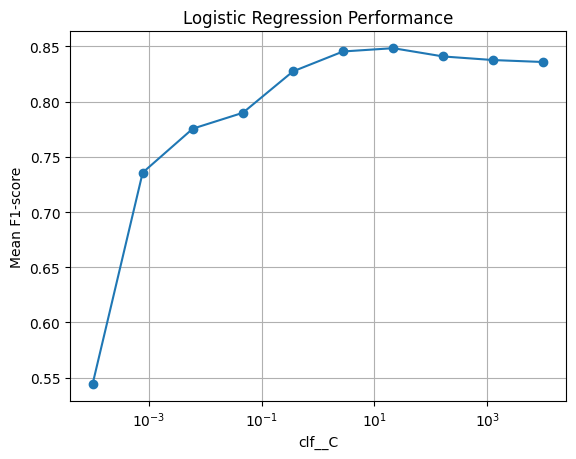

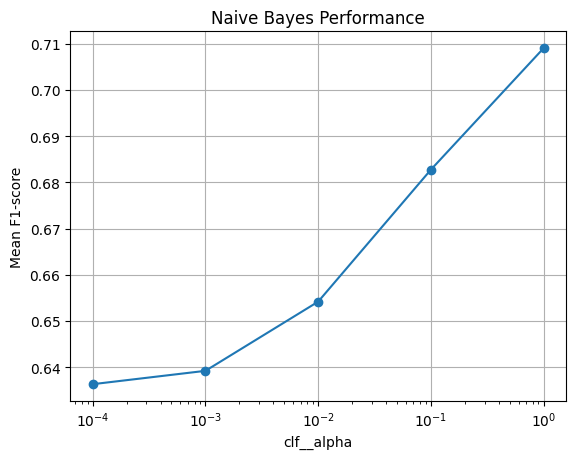

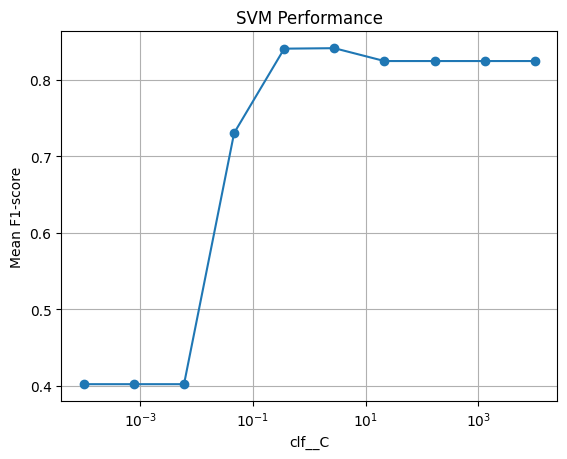

In [15]:
plot_scores(grid_lr, param_grid_lr, 'Logistic Regression')
plot_scores(grid_nb, param_grid_nb, 'Naive Bayes')
plot_scores(grid_svm, param_grid_svm, 'SVM')


In [16]:
# Utilisez le modèle qui a été choisi comme le meilleur précédemment
best_clf = best_model.best_estimator_.named_steps['clf']

# Créez un pipeline avec le prétraitement et le modèle sélectionné
pipe = Pipeline([
    ('preprocessor', TextPreprocessorTransformer()),
    ('vectorizer', TfidfVectorizer()),
    ('clf', best_clf)
])

# Définissez les paramètres de prétraitement à optimiser
param_grid = {
    'preprocessor__remove_punct': [True, False],
    'preprocessor__lowercase': [True, False],
    'preprocessor__remove_digits': [True, False],
    'preprocessor__remove_stopwords': [True, False],
    'preprocessor__stem': [True, False],
    'preprocessor__first_and_last_line_only': [True, False],
}

# Configurez la validation croisée et la recherche des meilleurs paramètres de prétraitement
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')

# Entraînez et optimisez le modèle avec les paramètres de prétraitement
grid_search.fit(alltxts, alllabs)

# Affichez les performances et les meilleurs paramètres de prétraitement
print("Meilleur score :", grid_search.best_score_)
print("Meilleurs paramètres de prétraitement :", grid_search.best_params_)


Meilleur score : 0.8505046990837204
Meilleurs paramètres de prétraitement : {'preprocessor__first_and_last_line_only': True, 'preprocessor__lowercase': False, 'preprocessor__remove_digits': False, 'preprocessor__remove_punct': False, 'preprocessor__remove_stopwords': True, 'preprocessor__stem': False}


In [17]:
param_optis_gs=grid_search.best_params_
param_optis={}
for param,truthvalue in param_optis_gs.items():
    nom_param=param.split('__')[1]
    param_optis[nom_param]=truthvalue
param_optis

{'first_and_last_line_only': True,
 'lowercase': False,
 'remove_digits': False,
 'remove_punct': False,
 'remove_stopwords': True,
 'stem': False}

## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents


In [22]:
input_file = r"ressources\AFDpresidentutf8\corpus.tache1.test.utf8"
output_file = "predictions_presidents.txt"
best_model = grid_svm.best_estimator_
preprocessor = TextPreprocessor(**param_optis)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(alltxts)

predict_from_txt(input_file, output_file, best_model, preprocessor,vectorizer)


<105:1> En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.

<105:1> En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.
Les prédictions ont été écrites dans le fichier : predictions_presidents.txt
